In [1]:
import torch
import pickle
import config
import os
import numpy as np
import evaluation as E
import matplotlib.pyplot as plt

In [2]:
# Device
device = config.device
# device = torch.device('cuda:0')
# device = 'cpu'

# Prepare data
## Datasets
datasets = os.listdir('./Datasets/datasets/')
datasets = [d for d in datasets if d.endswith('.p')]
datasets.sort()

## Load data
names   = []
num_in  = []
num_out = []
X_trains = []
y_trains = []
X_valids = []
y_valids = []
X_tests = []
y_tests = []

for dataset in datasets:
    datapath = os.path.join('./Datasets/datasets/' + dataset)
    with open(datapath, 'rb') as f:
        data = pickle.load(f)
        
    X_test     = data['X_test']
    y_test     = data['y_test']
    data_name  = data['name']

    N_class    = data['n_class']
    N_feature  = data['n_feature']
    N_test     = X_test.shape[0]
    
    print('Loading', data_name, N_feature, N_class, N_test)
    
    names.append(data_name)
    num_in.append(N_feature)
    num_out.append(N_class)
    
    X_tests.append(X_test.to(device))
    y_tests.append(y_test.to(device))

N_tasks = len(X_tests)
print('Finish data loading.')

Loading acuteinflammation 6 2 25
Loading acutenephritis 6 2 25
Loading balancescale 4 3 126
Loading blood 4 2 150
Loading breastcancer 9 2 58
Loading breastcancerwisc 9 2 140
Loading breasttissue 9 6 22
Loading ecoli 7 8 68
Loading energyy1 8 3 154
Loading energyy2 8 3 154
Loading fertility 9 2 21
Loading glass 9 6 43
Loading habermansurvival 3 2 62
Loading hayesroth 3 3 32
Loading ilpdindianliver 9 2 117
Loading iris 4 3 31
Loading mammographic 5 2 193
Loading monks1 6 2 111
Loading monks2 6 2 120
Loading monks3 6 2 110
Loading pima 8 2 154
Loading pittsburgbridgesMATERIAL 7 3 22
Loading pittsburgbridgesRELL 7 3 21
Loading pittsburgbridgesSPAN 7 3 18
Loading pittsburgbridgesTORD 7 2 20
Loading pittsburgbridgesTYPE 7 6 22
Loading postoperative 8 3 19
Loading seeds 7 3 43
Loading teaching 5 3 31
Loading tictactoe 9 2 192
Loading vertebralcolumn2clases 6 2 63
Loading vertebralcolumn3clases 6 3 63
Finish data loading.


In [3]:
alphas = np.logspace(np.log(1e-4), np.log(1e5), 51, base=np.e)
alphas = np.round(alphas, 5)
alphas_str = [str(alpha) for alpha in alphas]

In [4]:
Results = torch.zeros([len(alphas), 5, 2, N_tasks])

In [5]:
for a in range(len(alphas_str)):
    alpha = alphas_str[a]
    for seed in range(5):
        spnn = torch.load(f'./result/super pNN 58 semi/model/spnn_{alpha}_{seed}')
        with torch.no_grad():
            prediction = spnn(X_tests)
            Results[a, seed, 0, :] = torch.tensor(E.AccList(prediction, y_tests)).view(1,-1)
            Results[a, seed, 1, :] = spnn.GetNorm(config.pnorm)

In [6]:
Results.shape

torch.Size([51, 5, 2, 32])

In [7]:
Results[:,:,0,:] = Results[:,:,0,:] / Results[0,:,0,:]

In [8]:
ALPHAvsACC = Results[:,:,0,:]
ALPHAvsACC = torch.mean(ALPHAvsACC, dim=1)
ALPHAvsACC.shape

torch.Size([51, 32])

Text(0, 0.5, 'acc')

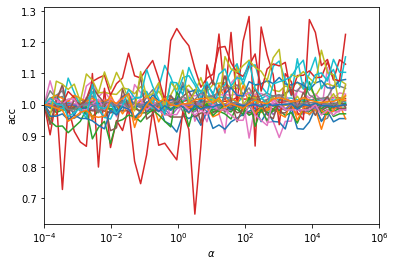

In [9]:
for t in range(N_tasks):
    plt.plot(np.array(alphas), ALPHAvsACC[:,t].numpy())
plt.xlim([1e-4, 1e6])
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'acc')

In [10]:
ALPHAvsACC_alltask = torch.mean(ALPHAvsACC, dim=1)

Text(0, 0.5, 'accuracy')

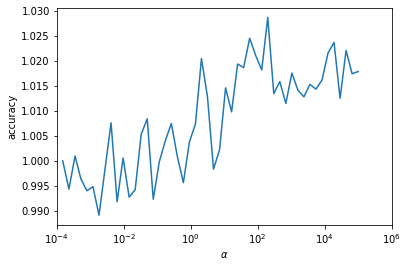

In [11]:
plt.plot(np.array(alphas)[1:], ALPHAvsACC_alltask.numpy()[:-1])
plt.xlim([1e-4, 1e6])
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'accuracy')

In [12]:
NORMvsACC = torch.mean(Results, dim=3)
NORMvsACC.shape

torch.Size([51, 5, 2])

In [13]:
NORMvsACC1 = NORMvsACC[:,:,0].view(1,-1)
NORMvsACC2 = NORMvsACC[:,:,1].view(1,-1)
NORMvsACC = torch.cat([NORMvsACC1, NORMvsACC2], dim=0)
NORMvsACC.shape

torch.Size([2, 255])

Text(0, 0.5, 'accuracy')

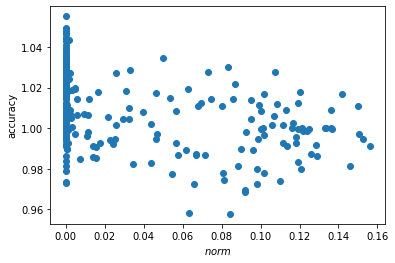

In [14]:
plt.scatter(NORMvsACC[1,:], NORMvsACC[0,:])
plt.xlabel(r'$norm$')
plt.ylabel(r'accuracy')

In [15]:
def HistoAcc(norm, acc, N=10):
    accs = []
    deltas = torch.linspace(torch.min(norm), torch.max(norm), N+1)
    for d in range(deltas.shape[0]-1):
        accs.append(torch.mean(acc[(deltas[d]<norm) & (norm<deltas[d+1])]))
    return accs, deltas[:-1]

In [16]:
acc,norm = HistoAcc(NORMvsACC[1,:], NORMvsACC[0,:])

Text(0, 0.5, 'accuracy')

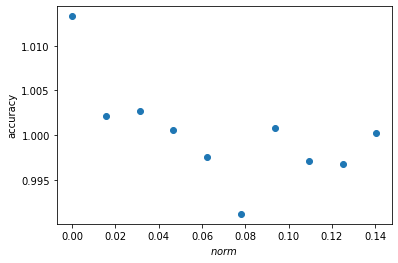

In [17]:
plt.scatter(norm, acc)
plt.xlabel(r'$norm$')
plt.ylabel(r'accuracy')